In [1]:
!pip install xgboost

In [2]:
import xgboost as xgb
print(xgb.__version__)

2.1.3


In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

In [192]:
# Load train, test, and validation datasets
train_path = '../APP-1/train.csv'
test_path = '../APP-1/test.csv'
val_path = '../APP-1/val_without_labels.csv'

train_data = pd.read_csv('../APP-1/train.csv')
test_data = pd.read_csv('../APP-1/test.csv')
validation_data = pd.read_csv('../APP-1/val_without_labels.csv')

In [193]:
train_data.head()

,Source_IP,Source_port,Destination_IP,Destination_port,Protocol,Timestamp,fwd_packets_amount,bwd_packets_amount,fwd_packets_length,bwd_packets_length,...,beaconning_15,beaconning_16,beaconning_17,beaconning_18,beaconning_19,pps_fwd,pps_bwd,count_big_requests,ACK_count,label
0,192.168.7.10,52264,3.232.242.170,443,tcp,1.728158e+09,870,2465,648,1629,...,0,0,0,0,0,16.183418,40.683315,25,2276,1inch.io
1,192.168.7.10,52286,3.232.242.170,443,tcp,1.728158e+09,871,2466,38,236,...,0,0,0,0,0,2.082513,12.933502,17,273,1inch.io
2,10.100.102.20,55125,172.64.148.206,443,udp,1.727977e+09,2281,2730,85,119,...,0,0,0,0,0,2.543558,3.560982,13,169,1inch.io
3,192.168.7.10,52287,3.232.242.170,443,tcp,1.728158e+09,872,2467,44,189,...,0,0,0,0,0,2.410077,10.352376,19,232,1inch.io
4,192.168.7.10,51187,54.154.220.45,443,tcp,1.728158e+09,12,23,13,23,...,0,0,0,0,0,10.436018,18.463725,6,35,1inch.io


In [194]:
# Shuffle train and test datasets, RandomForest accuracy is going down after shuffle
train_data = shuffle(train_data, random_state=42)
test_data = shuffle(test_data, random_state=42)

In [195]:
# After Shuffle
train_data.head()

,Source_IP,Source_port,Destination_IP,Destination_port,Protocol,Timestamp,fwd_packets_amount,bwd_packets_amount,fwd_packets_length,bwd_packets_length,...,beaconning_15,beaconning_16,beaconning_17,beaconning_18,beaconning_19,pps_fwd,pps_bwd,count_big_requests,ACK_count,label
570,192.168.1.25,55170,46.228.144.4,443,tcp,1.727397e+09,6653,16142,6653,16143,...,0,0,0,0,0,59.380749,144.082885,3,22795,veoh
265,10.100.102.20,61697,146.75.73.55,443,tcp,1.726409e+09,743,1086,1,1,...,0,0,0,0,0,14.736660,14.736660,0,2,forbes
291,10.100.102.20,60075,140.82.121.5,443,tcp,1.728409e+09,2,2,19,16,...,0,0,0,0,0,0.625957,0.527121,7,34,github
597,192.168.1.23,58755,34.111.199.139,443,udp,1.718463e+09,16,14,12,9,...,0,0,0,0,0,61.723906,46.292929,6,18,walla
174,10.100.102.20,65491,65.9.112.85,443,tcp,1.728436e+09,626,956,328,447,...,0,0,0,0,0,121.955350,166.201345,3,774,disneymovieinsiders


In [196]:
validation_data.shape

(30097, 111)

In [197]:
# 1. Data Exploration
## Check for missing values
print("Missing values in train dataset:\n", train_data.isnull().sum())
print("Missing values in test dataset:\n", test_data.isnull().sum())

## Label distribution
print("Label distribution in train dataset:\n", train_data['label'].value_counts())
print("Label distribution in test dataset:\n", test_data['label'].value_counts())

Missing values in train dataset:
 Source_IP             0
Source_port           0
Destination_IP        0
Destination_port      0
Protocol              0
                     ..
pps_fwd               0
pps_bwd               0
count_big_requests    0
ACK_count             0
label                 0
Length: 112, dtype: int64
Missing values in test dataset:
 Source_IP             0
Source_port           0
Destination_IP        0
Destination_port      0
Protocol              0
                     ..
pps_fwd               0
pps_bwd               0
count_big_requests    0
ACK_count             0
label                 0
Length: 112, dtype: int64
Label distribution in train dataset:
 label
veoh         5
forbes       5
politico     5
wprdc.org    5
espn         5
            ..
nytimes      5
axios        5
1inch.io     5
bloomberg    5
upbit        5
Name: count, Length: 128, dtype: int64
Label distribution in test dataset:
 label
veoh         5
forbes       5
politico     5
wprdc.org    5
es

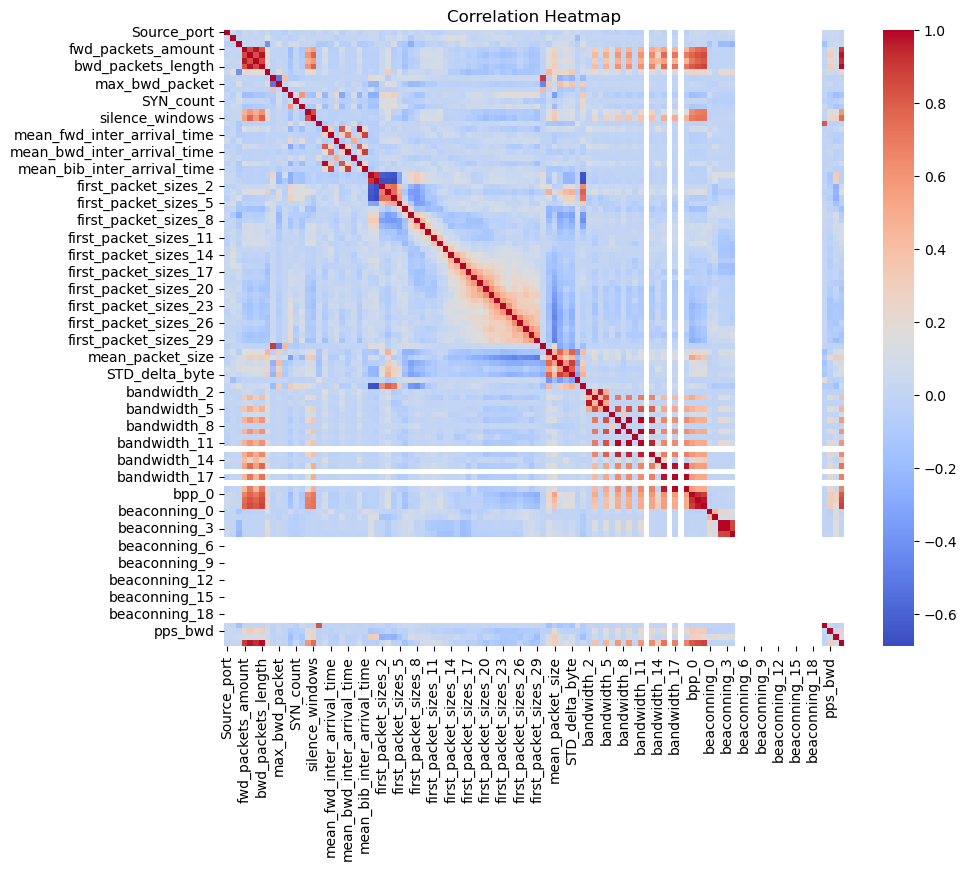

In [198]:
## Correlation heatmap for numerical features in train dataset
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(train_data[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [199]:
# Filter highly correlated features based on correlation threshold
def filter_highly_correlated_features(data, numeric_columns, threshold=0.9):
    corr_matrix = data[numeric_columns].corr()  # Compute the correlation matrix for numeric columns
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identify features with high correlation
    to_drop = [
        column for column in upper_triangle.columns 
        if any(upper_triangle[column] > threshold) and column != 'label'
    ]
    print(f"Features to suggest for dropping due to high correlation (>{threshold}): {to_drop}")
    return to_drop

# # Get list of features to drop
# features_to_drop = filter_highly_correlated_features(
#     train_data, numeric_cols, threshold=0.9
# )

In [200]:
# #colums_to_drop = ['beaconning_0','beaconning_1','beaconning_2',	'beaconning_3',	'beaconning_4',	'beaconning_5',	'beaconning_6'	,'beaconning_7',	'beaconning_8',	'beaconning_9',	'beaconning_10','beaconning_11','beaconning_12','beaconning_13','beaconning_14','beaconning_15','beaconning_16','beaconning_17','beaconning_18','beaconning_19']
# origin_to_drop = ['Source_IP', 'Destination_IP']
# # 2. Data Preprocessing
# def preprocess_data(data, is_training=True, label_encoder=None):
#     # Drop unnecessary columns
#     data_cleaned = data.drop(origin_to_drop, axis=1)
    
#     # Encode label column if in training or testing
#     if is_training and 'label' in data_cleaned.columns:
#         data_cleaned['label'] = label_encoder.fit_transform(data_cleaned['label'])
#     elif 'label' in data_cleaned.columns:
#         data_cleaned['label'] = label_encoder.transform(data_cleaned['label'])
    
#     # One-hot encode 'Protocol'
#     data_cleaned = pd.get_dummies(data_cleaned, columns=['Protocol'], drop_first=True)
#     return data_cleaned

In [201]:
# 2. Data Preprocessing
def preprocess_data(data, is_training=True, label_encoder=None, features_to_drop=None):
    # Drop highly correlated features if provided
    if features_to_drop:
        data = data.drop(columns=[col for col in features_to_drop if col in data.columns], errors='ignore')

    # Encode label column if in training or testing
    if is_training and 'label' in data.columns:
        data['label'] = label_encoder.fit_transform(data['label'])
    elif 'label' in data.columns:
        data['label'] = label_encoder.transform(data['label'])
    
    # One-hot encode 'Protocol'
    if 'Protocol' in data.columns:
        data = pd.get_dummies(data, columns=['Protocol'], drop_first=True)
    else:
        print("Warning: 'Protocol' column not found for one-hot encoding.")
    return data

In [202]:
# Initialize label encoder
le_label = LabelEncoder()

# Preprocess train and test datasets
# train_cleaned = preprocess_data(train_data, is_training=True, label_encoder=le_label)
# test_cleaned = preprocess_data(test_data, is_training=True, label_encoder=le_label)

# Preprocess train and test datasets
train_cleaned = preprocess_data(filtered_train_data, is_training=True, label_encoder=le_label)
test_cleaned = preprocess_data(filtered_test_data, is_training=True, label_encoder=le_label)


KeyError: "['label'] not found in axis"

In [189]:
# # Separate features and target
# X_train = train_cleaned.drop('label', axis=1).select_dtypes(include=[np.number])
# y_train = train_cleaned['label']
# X_test = test_cleaned.drop('label', axis=1).select_dtypes(include=[np.number])
# y_test = test_cleaned['label']

KeyError: "['label'] not found in axis"

In [180]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# X_train_dup_scaled = scaler.transform(X_train_dup)

In [181]:
# 3. Model Training
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [182]:
# Evaluate on test data
y_pred_test = rf_clf.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Random Forest Accuracy on Test Dataset: {accuracy_test:.2f}")
print("Random Forest Accuracy on Test Dataset: {0:.2f}%".format(accuracy_test*100))
print("Classification Report on Test Dataset:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix on Test Dataset:\n", confusion_matrix(y_test, y_pred_test))

Random Forest Accuracy on Test Dataset: 0.56
Random Forest Accuracy on Test Dataset: 56.09%
Classification Report on Test Dataset:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.75      0.60      0.67         5
           2       0.67      0.40      0.50         5
           3       0.75      0.60      0.67         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       0.40      0.40      0.40         5
           7       0.71      1.00      0.83         5
           8       0.67      0.40      0.50         5
           9       0.38      0.60      0.46         5
          10       0.80      0.80      0.80         5
          11       0.40      0.80      0.53         5
          12       0.50      0.20      0.29         5
          13       0.50      0.40      0.44         5
          14       0.50      0.20      0.29         5
   

C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [140]:
# Feature Importance Analysis
feature_importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

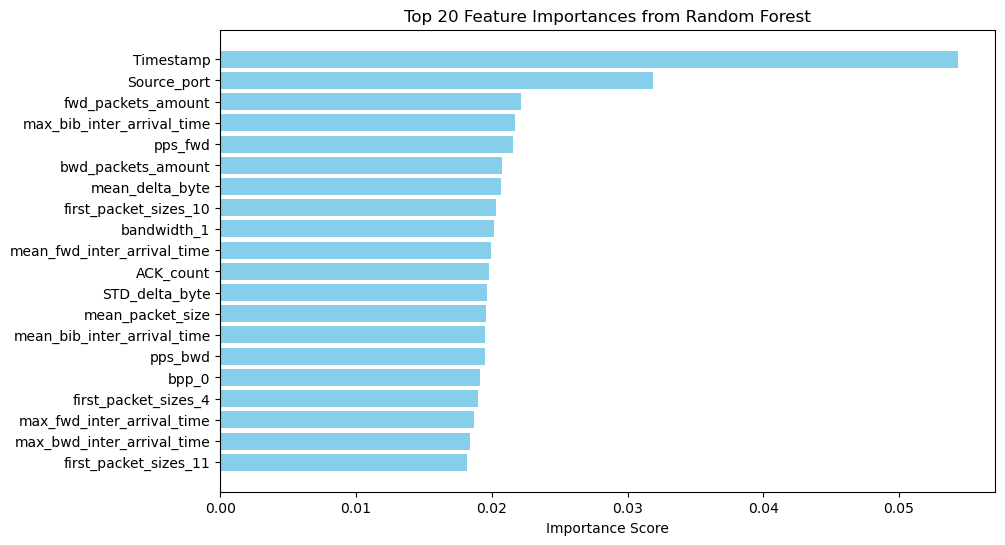

In [141]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(20)  # Top 10 features
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [142]:
# 4. Hyperparameter Tuning with RandomizedSearchCV
# This train can take 5 minutes
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=50,  # Test 50 random combinations
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)
randomized_search.fit(X_train_scaled, y_train)
print("Best Parameters from RandomizedSearchCV:", randomized_search.best_params_)

Best Parameters from RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


In [143]:
# Train Random Forest with best parameters
rf_best_clf = randomized_search.best_estimator_
y_pred_best = rf_best_clf.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Optimized Random Forest Accuracy on Test Dataset: {accuracy_best:.2f}")
print("Optimized Random Forest Accuracy on Test Dataset: {0:.2f}%".format(accuracy_best*100))

Optimized Random Forest Accuracy on Test Dataset: 0.59
Optimized Random Forest Accuracy on Test Dataset: 58.75%


In [145]:
# Train XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy on Test Dataset: {accuracy_xgb:.2f}")
print("XGBoost Accuracy on Test Dataset (Origin Train Data): {0:.2f}%".format(accuracy_xgb*100))

# # Add Predictions to Test Data
# test_data['RandomForest_Prediction'] = le_label.inverse_transform(y_pred_best)
# test_data['XGBoost_Prediction'] = le_label.inverse_transform(y_pred_xgb)

# # Save updated test data
# test_data.to_csv(test_path, index=False)
# print("Test predictions with Random Forest and XGBoost saved.")


XGBoost Accuracy on Test Dataset: 0.60
XGBoost Accuracy on Test Dataset (Origin Train Data): 60.31%


In [129]:
# 5. Validation Predictions
validation_cleaned = preprocess_data(validation_data, is_training=False, label_encoder=le_label)

# Ensure feature alignment with training data
missing_cols = set(X_train.columns) - set(validation_cleaned.columns)
for col in missing_cols:
    validation_cleaned[col] = 0
validation_cleaned = validation_cleaned[X_train.columns]  # Align feature order

# Standardize validation features
validation_scaled = scaler.transform(validation_cleaned)

# Predict on validation data using Random Forest
validation_predictions_rf = rf_best_clf.predict(validation_scaled)
validation_data['RandomForest_Prediction'] = le_label.inverse_transform(validation_predictions_rf)

# Predict on validation data using XGBoost
validation_predictions_xgb = xgb_clf.predict(validation_scaled)
validation_data['XGBoost_Prediction'] = le_label.inverse_transform(validation_predictions_xgb)

In [61]:
# Save validation predictions
validation_data.to_csv('../APP-1/val_without_labels.csv', index=False)
print("Validation predictions with Random Forest and XGBoost saved.")

Validation predictions with Random Forest and XGBoost saved.


In [67]:
# Summary Results
print("\nSummary Results:")
print(f"Initial Random Forest Accuracy: {accuracy_test:.2f}")
print(f"Optimized Random Forest Accuracy: {accuracy_best:.2f}")
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")


Summary Results:
Initial Random Forest Accuracy: 0.56
Optimized Random Forest Accuracy: 0.59
XGBoost Accuracy: 0.60
